# MechIR Activation Patching

This notebook serves to walk you through a simple example of activation patching in `MechIR`. For more details on the specifics of this process check out our other notebook!.

NOTE: Our initial implementation is flexible enough to support loading a wide variety of Transformer-based IR models, but we have mainly tested the following models:
- TAS-B (bi-encoder) [[Hofstätter et al.]](https://arxiv.org/abs/2104.06967) [[HF model card]](https://huggingface.co/sebastian-hofstaetter/distilbert-dot-tas_b-b256-msmarco)
- monoELECTRA (cross-encoder) [[Pradeep et al.]](https://link.springer.com/chapter/10.1007/978-3-030-99736-6_44) [[HF model card]](https://huggingface.co/crystina-z/monoELECTRA_LCE_nneg31)

## Setup

In [16]:
%pip install -U -q git+https://github.com/Parry-Parry/MechIR.git@sae
%pip install -q transformer_lens
%pip install -q matplotlib seaborn plotly

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [1]:
from mechir import Dot, Cat
from mechir.data import MechIRDataset, DotDataCollator, CatDataCollator
from mechir.perturb import perturbation
from mechir.plotting import plot_components

import torch
from torch.utils.data import DataLoader

/opt/anaconda3/envs/mechir/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-08 12:01:05.170 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


## Load Model

* `Dot` : A bi-encoder architecture with flexibility for different BERT architectures and pooling forms.
* `Cat` : A cross-encoder architecture with with flexibility for different BERT architectures. Checkout our `monoT5` class if you want to work with sequence-to-sequence models!

In [2]:
model_name = "sebastian-hofstaetter/distilbert-dot-tas_b-b256-msmarco"
model = Dot(model_name)

If using BERT for interpretability research, keep in mind that BERT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model sebastian-hofstaetter/distilbert-dot-tas_b-b256-msmarco into HookedEncoder


In [3]:
cat_model_name = "crystina-z/monoELECTRA_LCE_nneg31"
cat_model = Cat(cat_model_name)

If using BERT for interpretability research, keep in mind that BERT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model crystina-z/monoELECTRA_LCE_nneg31 into HookedEncoder


## Load Dataset

We recommend the use of `ir-datasets` as it is the easiest way to get started with MechIR. By default `MechIR` will load relevance judgements from these datasets however you can change this or even use your own documents and queries using the `MechDataset` class.

In [4]:
# Load smallest dataset for quick testing
dataset = MechIRDataset("vaswani")
dataset.pairs.head()

,query_id,doc_id,relevance,iteration
0,1,1239,1,0
1,1,1502,1,0
2,1,4462,1,0
3,1,4569,1,0
4,1,5472,1,0


In [5]:
# Print examples of queries
print("Total queries in dataset:", len(dataset.queries.items()))
print("\n----------- Examples of queries: -----------\n")
example_queries = list(dataset.queries.values())[:3]
for query in example_queries:
    print(query)

Total queries in dataset: 93

----------- Examples of queries: -----------

MEASUREMENT OF DIELECTRIC CONSTANT OF LIQUIDS BY THE USE OF MICROWAVE TECHNIQUES

MATHEMATICAL ANALYSIS AND DESIGN DETAILS OF WAVEGUIDE FED MICROWAVE RADIATIONS

USE OF DIGITAL COMPUTERS IN THE DESIGN OF BAND PASS FILTERS HAVING GIVEN PHASE AND ATTENUATION CHARACTERISTICS



In [6]:
# Calculate document stats
doc_lengths = [len(doc.split()) for doc in dataset.docs.values()]

# Print examples of documents
print("Total documents in dataset:", len(dataset.docs.items()))
print(f"Minimum Length (in words): {min(doc_lengths)}")
print(f"Maximum Length (in words): {max(doc_lengths)}")
print(f"Average Length (in words): {(sum(doc_lengths) / len(doc_lengths) if doc_lengths else 0):.2f}")
print("\n----------- Examples of documents: -----------\n")
example_docs = list(dataset.docs.values())[:3]
for doc in example_docs:
    print(doc)

Total documents in dataset: 11429
Minimum Length (in words): 2
Maximum Length (in words): 269
Average Length (in words): 41.93

----------- Examples of documents: -----------

compact memories have flexible capacities  a digital data storage
system with capacity up to bits and random and or sequential access
is described

an electronic analogue computer for solving systems of linear equations
mathematical derivation of the operating principle and stability
conditions for a computer consisting of amplifiers

electronic coordinate transformer  circuit details are given for
the construction of an electronic calculating unit which enables
the polar coordinates of a vector modulus and cosine or sine of the
argument to be derived from those of a rectangular system of axes



In [7]:
# Print example of one query and relevant documents
query_rel_doc_ex_df = dataset.pairs.head(3)[["query_id", "doc_id"]]
query_id = query_rel_doc_ex_df["query_id"].unique()[0]
doc_ids = query_rel_doc_ex_df["doc_id"]
print(f"Query: {dataset.queries[query_id]}")
print("-------------------------------")
for doc_id in doc_ids:
    print(f"Document:\n{dataset.docs[doc_id]}")

Query: MEASUREMENT OF DIELECTRIC CONSTANT OF LIQUIDS BY THE USE OF MICROWAVE TECHNIQUES

-------------------------------
Document:
broadband millimetre wave paramagnetic resonance spectrometer  the
specimen and waveguide which can be cooled by means of a cryostat
are placed between close pole pieces giving high uniform magnetic
fields  design details and some measurements on zero field splittings
are given

Document:
microwave measurements of dielectric absorption in dilute solutions

Document:
dielectric properties of ice at very low frequencies and the influence
of a polarizing field  measurements at frequencies down to are reported
the loss factor passes through a low frequency maximum which is distinguishable
from that associated with the dipole dispersion by its different
temperature dependence  the effect of impurities is to shift the
maximum towards higher frequencies  application of a unidirectional
field does not affect the permittivity of the pure crystals but eliminates
the 

### Paired Dataset Creation

Activation patching relies on pairs of inputs, consisting of one *perturbed* input and one *baseline* input, where the *perturbed* input is constructed by applying some function to modify an *original* input (e.g., inserting a query term to the end of a document) and the *baseline* input is a padded variant of the *original* input to maintain token lengths between the pairs.

In the main demo, we show one possible type of perturbation (appending a query term to the end of a document), but there are several other possible types of functions that could be use to generate the activation patching input pairs depending on what behavior you are trying to investigate. In this section, we discuss possible general perturbation methods, and describe some specific perturbations that we define aligning with IR axioms.

In [8]:
# Helper function just to print
def pretty_print_triplets(batch, tokenizer):
    """
    Pretty prints triplets of queries, documents, and their corresponding perturbed documents from a batch.

    Args:
        batch (dict): A dictionary containing 'queries', 'documents', and 'perturbed_documents' from a DataLoader.
        tokenizer: The tokenizer used to decode the input IDs.
    """
    # Get the queries, documents, and perturbed documents from the batch
    queries = batch["queries"]
    documents = batch["documents"]
    perturbed_documents = batch["perturbed_documents"]

    # Loop through the batch size
    for i in range(len(documents["input_ids"])):
        # Get the input IDs
        query_ids = queries["input_ids"][i]
        original_ids = documents["input_ids"][i]
        perturbed_ids = perturbed_documents["input_ids"][i]

        # Decode the input IDs to text
        query_decoded = tokenizer.decode(query_ids.tolist(), skip_special_tokens=False).replace("[PAD]", "").strip()
        original_doc_decoded = tokenizer.decode(original_ids.tolist(), skip_special_tokens=False).replace("[PAD]", "").strip()
        perturbed_doc_decoded = tokenizer.decode(perturbed_ids.tolist(), skip_special_tokens=False).replace("[PAD]", "").strip()

        # Pretty print
        print(f"Triplet {i + 1}:")
        print("Query:", query_decoded)
        print("Original Document:", original_doc_decoded)
        print("Perturbed Document:", perturbed_doc_decoded)
        print("=" * 50)  # Separator for clarity

## Make your own

In [9]:
@perturbation(perturb_type="replace")
def my_perturbation(text: str, query: str = None) -> str:
    """
    A simple perturbation function that replaces the first word of the text with 'REPLACED'.

    Args:
        text (str): The input text to be perturbed.

    Returns:
        str: The perturbed text.
    """
    words = text.split()
    if words:
        words[0] = "REPLACED"
    return " ".join(words)

# Using Perturbations

Once you have a perturbation and a dataset, we provide collate functions which automatically apply your perturbation to your dataset and allow batching for more efficient experiments. A standard torch dataloader is all you need but remember that different architectures need different input formats so make sure to use the correct collate functon for your model.

In [10]:
data_collator = DotDataCollator(model.tokenizer, my_perturbation, perturb_type="replace")
dataloader = DataLoader(dataset, batch_size=1, collate_fn=data_collator)

In [11]:
cat_data_collator = CatDataCollator(cat_model.tokenizer, my_perturbation, perturb_type="replace")
cat_dataloader = DataLoader(dataset, batch_size=1, collate_fn=cat_data_collator)

In [12]:
for i, batch in enumerate(dataloader):
    pretty_print_triplets(batch, model.tokenizer)

    # stop after 2 batches
    if i == 1:
        break

Triplet 1:
Query: [CLS] measurement of dielectric constant of liquids by the use of microwave techniques [SEP]
Original Document: [CLS] broadband millimetre wave paramagnetic resonance spectrometer the specimen and waveguide which can be cooled by means of a cryostat are placed between close pole pieces giving high uniform magnetic fields design details and some measurements on zero field splittings are given [SEP]
Perturbed Document: [CLS] replaced millimetre wave paramagnetic resonance spectrometer the specimen and waveguide which can be cooled by means of a cryostat are placed between close pole pieces giving high uniform magnetic fields design details and some measurements on zero field splittings are given [SEP]
Triplet 1:
Query: [CLS] measurement of dielectric constant of liquids by the use of microwave techniques [SEP]
Original Document: [CLS] microwave measurements of dielectric absorption in dilute solutions [SEP]
Perturbed Document: [CLS] replaced measurements of dielectric a

### Verify Difference in Performance on Perturbed Pairs

Before we can finalize our paired dataset and proceedto the patching experiments, there's a couple things to check:
- Does the chosen perturbation even have an effect on model behavior?
- If yes, what is that effect? (i.e., Do the *baseline* or *perturbed* inputs have a higher relevance score on average?)

So first, let's calculate the performances of the three toy perturbations we defined earlier (prepend, append, replace) and plot their distributions.

In [13]:
# Helper function for plotting difference in performance
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_score_dists(baseline_scores, perturbed_scores, type="hist"):
    plt.figure(figsize=(8, 6))

    if type == "hist":
        plt.hist(baseline_scores, label='Baseline', color='blue')
        plt.hist(perturbed_scores, label='Perturbed', color='orange')
        plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('Frequency')
    elif type == "box":
        plt.boxplot([baseline_scores, perturbed_scores], labels=['Baseline', 'Perturbed'])
        plt.ylabel('Scores')

    plt.xlabel('Scores')
    plt.title('Distribution of Baseline vs Perturbed Scores')
    plt.legend()

    plt.show()

    return

In [14]:
baseline_performance, perturbed_performance = [], []
for i, batch in enumerate(cat_dataloader):
    # Get the queries, documents, and perturbed documents from the batch
    sequences = batch["sequences"]
    perturbed_sequences = batch["perturbed_sequences"]

    baseline_scores = model.forward(**sequences) # [batch_size x 1]
    perturbed_scores = model.forward(**perturbed_sequences) # [batch_size x 1]

    baseline_performance += baseline_scores.flatten().tolist()
    perturbed_performance += perturbed_scores.flatten().tolist()

    # stop after 2 batches
    if i == 1:
        break

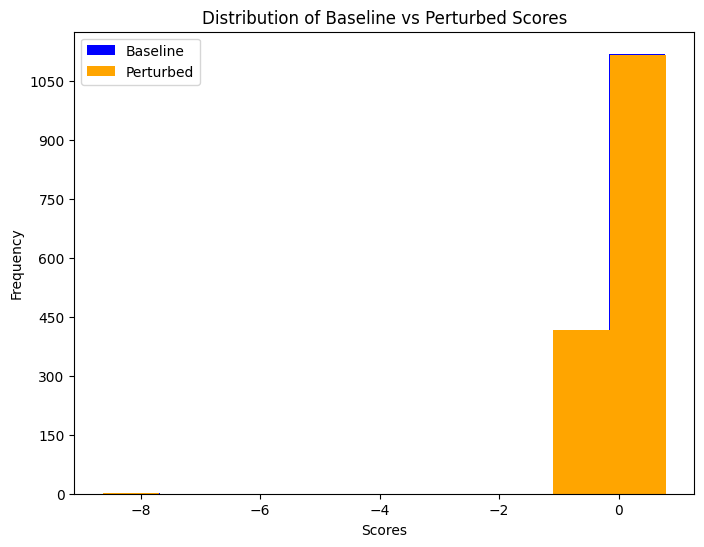

In [15]:
plot_score_dists(baseline_performance, perturbed_performance)

/var/folders/8_/slwlpfyn0w34d9zzt9s9qk_c0000gn/T/ipykernel_82715/956876871.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([baseline_scores, perturbed_scores], labels=['Baseline', 'Perturbed'])
/var/folders/8_/slwlpfyn0w34d9zzt9s9qk_c0000gn/T/ipykernel_82715/956876871.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


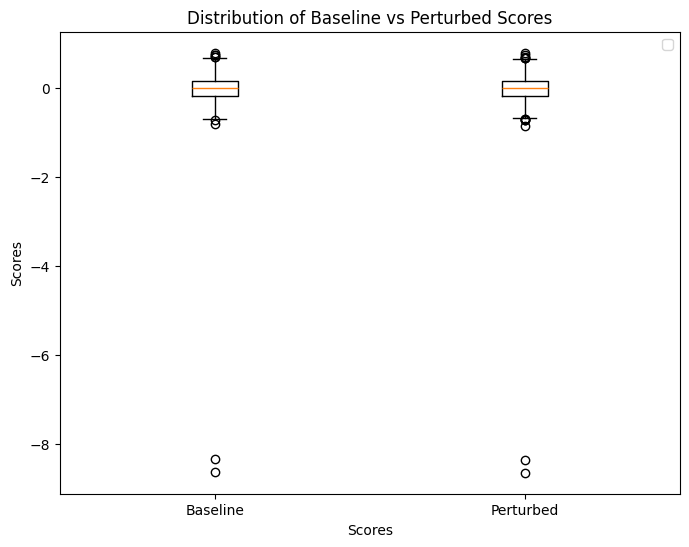

In [16]:
plot_score_dists(baseline_performance, perturbed_performance, type="box")

In [ ]:
ITERS=10
patching_head_outputs = []
for i, batch in enumerate(cat_dataloader):
    # Get the queries, documents, and perturbed documents from the batch
    sequences = batch["sequences"]
    perturbed_sequences = batch["perturbed_sequences"]
    patch_head_out = cat_model.patch(sequences, perturbed_sequences, patch_type="head_all")
    patching_head_outputs.append(patch_head_out)
    
    if i == ITERS:
        break
mean_head_outputs = torch.mean(torch.stack(patching_head_outputs), axis=0)

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


RuntimeError: The size of tensor a (330) must match the size of tensor b (2) at non-singleton dimension 1

In [ ]:
plot_components(mean_head_outputs)